In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive

/content/drive/MyDrive


In [3]:
# !pip install sentencepiece
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 18.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.5 MB/s eta 0:00:00
  Preparing metadata

In [4]:
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
import os
import json

In [5]:
import os
import json
import re
from zipfile import ZipFile

cond = re.compile('[가-힣]+')

def get_data_from_zip(zip_name):
    zip_file_path = '/content/drive/MyDrive/jolnon/' + zip_name + '.zip'
    extract_path = '/content/' + zip_name

    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    result = []
    for name in os.listdir(path=extract_path):
        file_path = os.path.join(extract_path, name)
        if os.path.isdir(file_path):
            for name in os.listdir(path=file_path):
                with open(file_path + '/' + name, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    valid = []
                    for d in data['content'].split('\n'):
                        res = []
                        for word in d.split(' '):
                            if cond.match(word) != None:
                                res.append(word)
                        d = ' '.join(res)
                        if d and not d.replace(' ', '').isdecimal():
                            valid.append(d)
                    result.append('\n'.join([data['title']] + valid))
        else:
            with open(extract_path + '/' + name, 'r', encoding='utf-8') as f:
                data = json.load(f)
                valid = []
                for d in data['content'].split('\n'):
                    res = []
                    for word in d.split(' '):
                        if cond.match(word) != None:
                            res.append(word)
                    d = ' '.join(res)
                    if d and not d.replace(' ', '').isdecimal():
                        valid.append(d)
                result.append('\n'.join([data['title']] + valid))
    return result


In [6]:
import random
random.seed(42)
galleries = ['animal','tree']
dataset = []
for e in galleries:
  dataset.append([get_data_from_zip(e)])
cocktail = []
for data in dataset:
  for sen in data:
    cocktail+=sen

In [7]:
def remove_words(sentence, word):
    return ' '.join([w.replace(word, '') for w in sentence.split()])
stopwords = ['-dc', 'official', 'App', '이미지' ,'순서','저장','.jpg','.png','.txt','.gif']
for i in range(len(cocktail)):
  for j in range(len(stopwords)):
    cocktail[i] = remove_words(cocktail[i],stopwords[j])

In [8]:
import collections

def remove_top_n_words(data, n):
    words = [word for sentence in data for word in sentence.split(' ')]
    word_count = collections.Counter(words)
    top_n_words = [word for word, _ in word_count.most_common(n)]
    for i in range(len(data)):
        for word in top_n_words:
            if word=='':
                continue
            data[i] = remove_words(data[i], word)
    return data

def remove_empty_sentences(cocktail, real_labels):
  indices = [i for i, sentence in enumerate(cocktail) if sentence.strip() != '']
  cocktail = [cocktail[i] for i in indices]
  real_labels = [real_labels[i] for i in indices]
  return cocktail, real_labels


In [9]:
real_labels = []
for i in range(len(dataset)):
  real_labels += [i] * len(dataset[i][0])
cocktail = remove_top_n_words(cocktail, 0)
cocktail, real_labels = remove_empty_sentences(cocktail, real_labels)

In [10]:
# !pip install transformers
# from transformers import AutoModel, AutoTokenizer
# model = AutoModel.from_pretrained("klue/roberta-large")
# tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

# model = AutoModel.from_pretrained("klue/bert-base")
# tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
# bertopic_model_embed_token = BERTopic(embedding_model=model,
#                                       vectorizer_model=vectorizer,
#                                       ctfidf_model=ctfidf_model,
#                                       nr_topics=100,
#                                       top_n_words=1,
#                                       calculate_probabilities=False)

In [11]:
from bertopic.vectorizers import ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
bertopic_model_embed_token = BERTopic(language='multilingual',
                          nr_topics=100,
                          top_n_words=1)
topics, _ = bertopic_model_embed_token.fit_transform(cocktail)

In [12]:
topic_info = bertopic_model_embed_token.get_topic_info()
number_of_topics = len(topic_info) - 1
print(f"생성된 주제의 수: {number_of_topics}")
lst = []
for index, row in topic_info.iterrows():
    topic_num = row['Topic']
    if topic_num != -1:
        topic_name = row['Name']
        pure_topic_name = "_".join(topic_name.split("_")[1:])
        lst.append(pure_topic_name)

생성된 주제의 수: 99


In [13]:
### Reducing outliers
topics = bertopic_model_embed_token.reduce_outliers(cocktail, topics, strategy="c-tf-idf", threshold=0.1)
topics = bertopic_model_embed_token.reduce_outliers(cocktail, topics, strategy="distributions")

In [14]:
hierarchical_topics = bertopic_model_embed_token.hierarchical_topics(cocktail)

100%|██████████| 98/98 [00:01<00:00, 94.36it/s]


In [15]:
# bertopic_model_embed_token.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [16]:
verify = True
table = [[0 for r in range(2)] for t in range(max([int(x) for x in hierarchical_topics['Parent_ID']]) + 1)]
if verify:
  for j in range(number_of_topics):
    for i in range(len(topics)):
      if topics[i]==j:
        table[j][real_labels[i]]+=1
  for j in range(number_of_topics, len(table)):
    row = hierarchical_topics[hierarchical_topics['Parent_ID'] == str(j)].iloc[0]
    left, right = int(row['Child_Left_ID']), int(row['Child_Right_ID'])
    for i in range(len(table[0])):
      table[j][i] += table[left][i] + table[right][i]

In [17]:
df = hierarchical_topics
selected_topics_ids = set()
for index, row in df[df['Distance'] >= 1].iterrows():
    left_child = df[df['Parent_ID'] == row['Child_Left_ID']]
    if not left_child.empty and left_child.iloc[0]['Distance'] < 1:
        selected_topics_ids.add(row['Child_Left_ID'])

    right_child = df[df['Parent_ID'] == row['Child_Right_ID']]
    if not right_child.empty and right_child.iloc[0]['Distance'] < 1:
        selected_topics_ids.add(row['Child_Right_ID'])
selected_topics_ids = list(selected_topics_ids)

In [18]:
post_counts = [0 for i in range(number_of_topics)]
for i in range(len(post_counts)):
    post_counts[i] = topics.count(i)

In [19]:
selected_topic_names=[]
for topic_id in selected_topics_ids:
    topic_name = df[df['Parent_ID'] == topic_id]['Parent_Name'].iloc[0]
    selected_topic_names.append(topic_name)

In [20]:
for i in range(len(selected_topic_names)):
  print(selected_topic_names[i], selected_topics_ids[i])

유혈목이 161
나무 127
로보쿤 128
곰스터 160
서울 158
고양이 142
냄새 124
사진 112
일베 164
유튜브 163
뚱땡정글 168
빨리 136
버섯 145
이름이 99
코코넛 153
거미줄 144
식물 113
제라늄 162
꽃이 129
돼지 165
자고 110
나무위키 166
토마토 133
햄스터 143
잠자는쥐 157
잎이 167
기니피그 156


In [21]:
# assert False

In [22]:
!pip install fasttext
import fasttext
from sklearn.cluster import KMeans
import numpy as np
from gensim import models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199771 sha256=aa496c046df9fbddf318195856f38c9811a4223a49d83ad9691107c402ce891f
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [23]:
model_path = '/content/drive/MyDrive/jolnon/cc.ko.150.bin'

m_fasttext = models.fasttext.load_facebook_model(model_path)

ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa1\x9c'; replacing invalid characters, using '\\xed\\xa1\\x9c'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xb0\x80'; replacing invalid characters, using '\\xed\\xb0\\x80'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa7\x80'; replacing invalid characters, using '\\xed\\xa7\\x80'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xb8\xb0'; replacing invalid characters, using '\\xed\\xb8\\xb0'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa0\x9c'; replacing invalid characters, using '\\xed\\xa0\\x9c'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa6\xac'; replacing invalid characters, using '\\xed\\xa6\\xac'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xb3\xb5'; replacing invalid characters, using '\\xed\\xb

In [ ]:
assert False
# 아래 chosen_topics를 설정한 후 실행하세요

In [24]:
chosen_topics = ['동물', '식물']

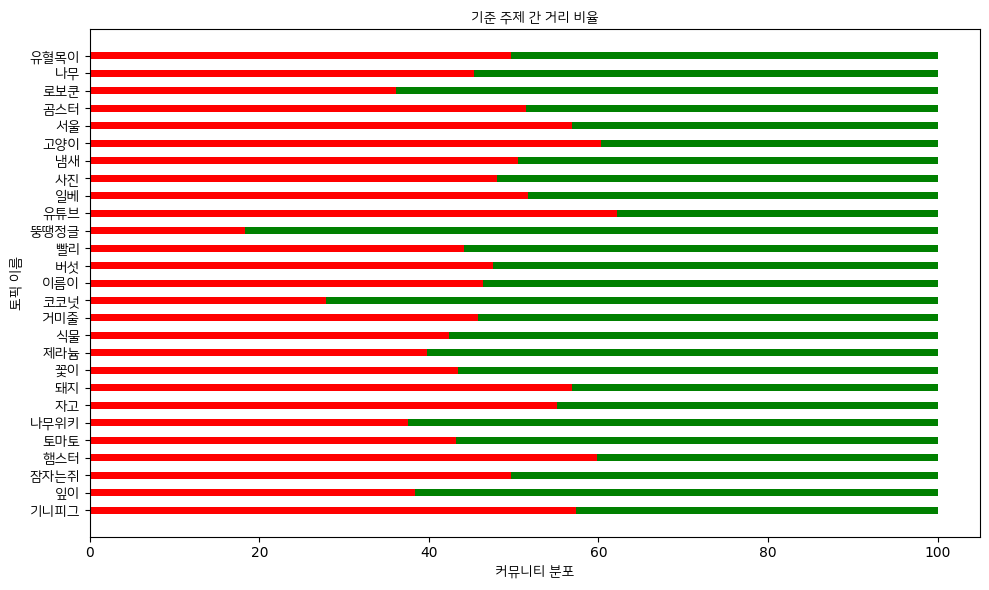

In [31]:
import warnings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

def cos_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def showTopicDistance(topics, selected_topic_names):
    distances = []
    standard_vecs = [m_fasttext.wv[x] for x in topics]

    font_path = '/content/drive/MyDrive/NanumSquareRoundR.ttf'
    fontprop = fm.FontProperties(fname=font_path, size=10)
    plt.rcParams["font.family"] = fontprop.get_name()
    plt.rcParams['axes.unicode_minus'] = False

    fig, ax = plt.subplots(figsize=(10, 6))

    y_positions = []
    y_labels = []

    y_positions = []
    current_y = 0
    bar_width = 0.4

    for i in range(len(selected_topic_names)):
        vec = m_fasttext.wv[selected_topic_names[i]]
        distances = []
        for j in range(len(topics)):
            distances.append(cos_sim(standard_vecs[j], vec))

        ratio = distances[0] / (distances[1] + 1e-14)

        current_y -= 1
        y_positions.append(current_y)
        y_labels.append(selected_topic_names[i])
        ax.barh(current_y, 100 * distances[0] / (distances[0] + distances[1]), color='r', height=bar_width, label=selected_topic_names[i])
        ax.barh(current_y, 100 * distances[1] / (distances[0] + distances[1]), color='g', left=ratio * 100 / (ratio + 1), height=bar_width)

    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels, fontproperties=fontprop)
    ax.set_xlabel('커뮤니티 분포', fontproperties=fontprop)
    plt.title("기준 주제 간 거리 비율", fontproperties=fontprop)
    plt.ylabel("토픽 이름", fontproperties=fontprop)

    plt.tight_layout()
    plt.show()

cRatio = showTopicDistance(chosen_topics, selected_topic_names)

In [26]:
# hierarchical_topics

In [27]:
# import numpy as np
# import warnings
# import matplotlib
# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# def clusterByHand(table, selected_topics_ids, selected_topic_names, galleries, post_counts, ord):
#   selected_topic_counts = [[0, 0] for _ in range(len(selected_topics_ids))]
#   for i in range(len(selected_topics_ids)):
#     selected_topic_counts[i][0] += table[int(selected_topics_ids[i])][0]
#     selected_topic_counts[i][1] += table[int(selected_topics_ids[i])][1]
#   dic = dict()
#   n_clusters = len(galleries) + 1
#   idx2name = dict(zip(selected_topics_ids,selected_topic_names))
#   name2idx = dict(zip(selected_topic_names,selected_topics_ids))
#   clustered_topics_name=[[],[],[]]
#   for i in range(len(ord)):
#     clustered_topics_name[ord[i]].append(selected_topic_names[i])

#   clustered_topics_count = [[] for _ in range(n_clusters)]
#   clustered_topics = [[] for _ in range(n_clusters)]
#   for i in range(len(clustered_topics_name)):
#     for ele in clustered_topics_name[i]:
#       clustered_topics[i].append(name2idx[ele])
#   for r in clustered_topics_name:
#     print(r)
#   cluster_sums = []
#   for idx, cluster in enumerate(clustered_topics):
#     total_sum = 0
#     for parent_id in cluster:
#       row = hierarchical_topics[hierarchical_topics['Parent_ID'] == parent_id].iloc[0]
#       topic_ids = row['Topics']
#       cluster_sum = sum(post_counts[topic_id] for topic_id in topic_ids)
#       clustered_topics_count[idx].append(cluster_sum)
#       total_sum += cluster_sum
#     cluster_sums.append(total_sum)
#   if verify:
#     clustered_count = [[0, 0] for _ in range(n_clusters)]
#     for i in range(n_clusters):
#       for j in clustered_topics[i]:
#         clustered_count[i][0] += table[int(j)][0]
#         clustered_count[i][1] += table[int(j)][1]

#     for i in range(n_clusters):
#       l, r = clustered_count[i][0], clustered_count[i][1]
#       for j in range(len(clustered_topics[i])):
#         k = clustered_topics[i][j]
#         l, r = table[int(k)][0], table[int(k)][1]
#     clusters = []

#     for i in range(n_clusters):
#       cluster_info = {}
#       l, r = clustered_count[i][0], clustered_count[i][1]
#       cluster_info['name'] = f'Cluster #{i+1}'
#       cluster_info['value'] = l + r
#       cluster_info['distribution'] = [100 * l / (l + r), 100 * r / (l + r)]

#       topics_list = []
#       for j in range(len(clustered_topics[i])):
#         topic_info = {}
#         k = clustered_topics[i][j]
#         l, r = table[int(k)][0], table[int(k)][1]
#         topic_info['name'] = clustered_topics_name[i][j]
#         topic_info['value'] = l + r
#         topic_info['distribution'] = [100 * l / (l + r), 100 * r / (l + r)]
#         topics_list.append(topic_info)

#       cluster_info['topics'] = topics_list
#       clusters.append(cluster_info)

#     font_path = '/content/drive/MyDrive/NanumSquareRoundR.ttf'
#     fontprop = fm.FontProperties(fname=font_path, size=10)
#     plt.rcParams["font.family"] = fontprop.get_name()
#     plt.rcParams['axes.unicode_minus'] = False

#     def sort_topics_by_distribution(cluster):
#       cluster['topics'] = sorted(cluster['topics'], key=lambda x: x['distribution'][0], reverse=True)

#     for cluster in clusters:
#       print(cluster)
#       sort_topics_by_distribution(cluster)

#     fig, ax = plt.subplots(figsize=(10, 6))

#     y_positions = []
#     y_labels = []

#     current_y = 0
#     bar_width = 0.4

#     for cluster in clusters:
#       y_positions.append(current_y)
#       y_labels.append(cluster['name'])
#       for topic in cluster['topics']:
#         current_y -= 1
#         y_positions.append(current_y)
#         y_labels.append(topic['name'])
#         ax.barh(current_y, topic['distribution'][0], color='r', height=bar_width, label=topic['name'])
#         ax.barh(current_y, topic['distribution'][1], color='g', left=topic['distribution'][0], height=bar_width)
#       current_y -= 2

#     ax.set_yticks(y_positions)
#     ax.set_yticklabels(y_labels, fontproperties=fontprop)
#     ax.set_xlabel('커뮤니티 분포', fontproperties=fontprop)
#     plt.title("FastText 이용 클러스터링 결과", fontproperties=fontprop)
#     plt.ylabel("토픽 이름", fontproperties=fontprop)

#     plt.tight_layout()
#     plt.show()

#     return clustered_topics


In [28]:
# clustered_topics_ids = clusterByHand(table, selected_topics_ids, selected_topic_names, galleries, post_counts, ord)
# ratios = [[] for i in range(3)]
# for i in range(3):
#   ratio = []

#   topics_list = []
#   for j in range(len(clustered_topics_ids[i])):
#     k = clustered_topics_ids[i][j]
#     l, r = table[int(k)][0], table[int(k)][1]
#     ratio.append(l / (l + r))
#   ratios[i] = ratio

In [29]:
# from scipy.stats import norm

# def plot_gaussian(data1, data2, data3):
#     print(data1, data2, data3)
#     # 각 데이터셋에 대한 평균과 표준편차를 계산
#     mu1, std1 = np.mean(data1), np.std(data1)
#     mu2, std2 = np.mean(data2), np.std(data2)
#     mu3, std3 = np.mean(data3), np.std(data3)

#     # 모든 데이터의 범위를 기반으로 x 값들을 샘플링
#     xmin = min(min(data1), min(data2), min(data3))
#     xmax = max(max(data1), max(data2), max(data3))
#     x = np.linspace(0, 1, 1000)

#     # 확률 밀도 함수 값을 계산
#     p1 = norm.pdf(x, mu1, std1)
#     p2 = norm.pdf(x, mu2, std2)
#     p3 = norm.pdf(x, mu3, std3)

#     # 그래프 그리기
#     plt.plot(x, p1, 'r', linewidth=2, label=f"Data1: µ={mu1:.2f}, σ={std1:.2f}")
#     plt.plot(x, p2, 'g', linewidth=2, label=f"Data2: µ={mu2:.2f}, σ={std2:.2f}")
#     plt.plot(x, p3, 'b', linewidth=2, label=f"Data3: µ={mu3:.2f}, σ={std3:.2f}")


#     plt.title("Gaussian Distributions")
#     plt.legend()
#     plt.show()

# plot_gaussian(*ratios)